In [1]:
import dlc_practical_prologue as prologue

In [2]:
import torch
import time
import numpy as np
from torch import nn
from torch.nn import functional as F
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [3]:
#Sometimes download directly will have http403 error
from six.moves import urllib
# have to add a header to your urllib request (due to that site moving to Cloudflare protection)
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
#*********************** 

In [4]:
# load training and testing data
N_PAIRS = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)

In [5]:
print(train_input.shape)
print(train_classes.shape)
print(train_target.shape)
print(test_input.shape)
print(test_classes.shape)
print(test_target.shape)

torch.Size([1000, 2, 14, 14])
torch.Size([1000, 2])
torch.Size([1000])
torch.Size([1000, 2, 14, 14])
torch.Size([1000, 2])
torch.Size([1000])


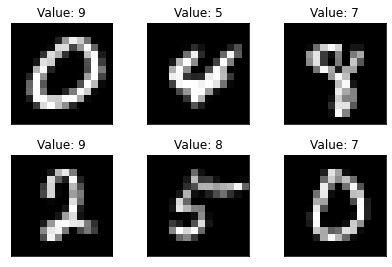

In [6]:
# displaying samples of data
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][0], cmap='gray')
  plt.title("Value: {}".format(train_classes[i][0]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

In [7]:
#weights_sharing_CNN
class CNN_Net_weight_sharing(nn.Module):
    def __init__(self):
        super(CNN_Net_weight_sharing, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,128,kernel_size=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2_drop=nn.Dropout2d()
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128,2)
        #parameters
        self.batch_size = 50
        self.criterion = nn.CrossEntropyLoss()
        self.num_epochs = 25
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        
        img1 = x[:,0,:,:].view(-1,1,14,14)
        img2 = x[:,1,:,:].view(-1,1,14,14)
        
        img1 = F.relu(F.max_pool2d(self.conv1(img1), kernel_size=2, stride=2))
        img1 = F.relu(F.max_pool2d(self.conv2(img1), kernel_size=2, stride=2))
        img2 = F.relu(F.max_pool2d(self.conv1(img2), kernel_size=2, stride=2))
        img2 = F.relu(F.max_pool2d(self.conv2(img2), kernel_size=2, stride=2))
        output = torch.cat((img1.view(-1, 512),img2.view(-1, 512)),1)
        output = F.relu(self.fc1(output))
        output = self.fc2(output)
        output = F.dropout(output,training=self.training)
        
        return output

        # Training Function

    def trainer(self, train_input, train_target, test_input, test_target):
        """
        Train the model on a training set
        :param train_input: Training features
        :param train_target: Training labels
        """
        
        start_time = time.time()
        train_loss_history=[]
        test_loss_history=[]
        train_accuracy=[]
        test_accuracy=[]
        for epoch in range(self.num_epochs):
            self.train()
            for batch_idx in range(0,train_input.size(0),self.batch_size):
                output = self(train_input[batch_idx:batch_idx+self.batch_size])
                target = train_target[batch_idx:batch_idx+self.batch_size]
                loss = self.criterion(output, target)  
                self.optimizer.zero_grad()                           #set the weight and bias gradients to zero
                loss.backward()                                #backpropagation
                self.optimizer.step()
                # print the loss in every 50 epoch
                if not batch_idx % 50:
                    print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.6f' 
                           %(epoch+1, self.num_epochs, batch_idx, 
                             len(train_input), loss))
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
            
            # test mode
            self.eval()
            # get the training loss and accuracy
            train_predicted = self(train_input)
            train_loss = self.criterion(train_predicted, train_target)
            train_loss_history.append(train_loss)
            _, train_pred = torch.max(train_predicted, 1)   #return the index of the bigger result
            train_accuracy_result=self.compute_accuracy(train_target,train_pred)
            train_accuracy.append(train_accuracy_result)

            # get the testing loss and accuracy
            test_predicted = self(test_input)
            test_loss = self.criterion(test_predicted, test_target)
            test_loss_history.append(test_loss)
            _, test_pred = torch.max(test_predicted, 1)   #return the index of the bigger result
            test_accuracy_result=self.compute_accuracy(test_target,test_pred)
            test_accuracy.append(test_accuracy_result)

        print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
        
        #Setting-up the plot
        plt.figure(figsize=(15,8))

        ax1 = plt.subplot(1,2,1)

        ax2 = plt.subplot(1,2,2)

        #Drawing and labeling the curves
        ax1.plot(train_loss_history, label="Training Loss")
        ax1.plot(test_loss_history, label="Test Loss")

        #Adding the title and axis labels
        ax1.set_title('Train VS Test Loss')
        ax1.set_ylabel('Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()

    #     #Saving the plot
    #     ax1.figure.savefig(model.model_name+'loss.png')


        #Drawing and labeling the curves
        ax2.plot(train_accuracy, label="Train Accuracy")
        ax2.plot(test_accuracy, label="Test Accuracy")

        #Adding the title and axis labels
        ax2.set_title('Train VS Test Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.legend()

        # Test error

    def compute_error(self, input_data, target):
        """
        Compute the number of error of the model on a test set
        :param input_data: test features
        :param target: test target
        :return: error rate of the input data
        """  
        #test mode
        self.eval()
        outputs= self(input_data)
        _, predicted = torch.max(outputs, 1)
        return 1-self.compute_accuracy(target,predicted)
    
    def compute_accuracy(self, target, pred):
        """
        Compute the training and testing error
        :param target: target data (whether 1 or 0)
        :param pred: predicted data
        :return 
        """
        return (target-pred).eq(0).float().mean().item()
    
    def save_model(self,model_name):
        """
        Save the model to a direction
        :param model_name: the model name, e.g. CNN_Net.pth
        """         
        torch.save(self, './model/'+ model_name)

In [8]:
# build the mdoel instance
my_model=CNN_Net_weight_sharing()
# save the model
my_model.save_model('CNN_Net_weight_sharing.pth')

Epoch: 001/025 | Batch 000/1000 | Loss: 12.532726
Epoch: 001/025 | Batch 050/1000 | Loss: 42.663795
Epoch: 001/025 | Batch 100/1000 | Loss: 33.313370
Epoch: 001/025 | Batch 150/1000 | Loss: 15.274073
Epoch: 001/025 | Batch 200/1000 | Loss: 3.734179
Epoch: 001/025 | Batch 250/1000 | Loss: 4.960681
Epoch: 001/025 | Batch 300/1000 | Loss: 5.495651
Epoch: 001/025 | Batch 350/1000 | Loss: 4.873060
Epoch: 001/025 | Batch 400/1000 | Loss: 2.363506
Epoch: 001/025 | Batch 450/1000 | Loss: 0.873026
Epoch: 001/025 | Batch 500/1000 | Loss: 1.750936
Epoch: 001/025 | Batch 550/1000 | Loss: 1.388542
Epoch: 001/025 | Batch 600/1000 | Loss: 1.545705
Epoch: 001/025 | Batch 650/1000 | Loss: 1.165174
Epoch: 001/025 | Batch 700/1000 | Loss: 1.003453
Epoch: 001/025 | Batch 750/1000 | Loss: 0.862154
Epoch: 001/025 | Batch 800/1000 | Loss: 0.960710
Epoch: 001/025 | Batch 850/1000 | Loss: 0.820184
Epoch: 001/025 | Batch 900/1000 | Loss: 0.921152
Epoch: 001/025 | Batch 950/1000 | Loss: 1.122172
Time elapsed: 0.

Epoch: 009/025 | Batch 300/1000 | Loss: 0.404628
Epoch: 009/025 | Batch 350/1000 | Loss: 0.323132
Epoch: 009/025 | Batch 400/1000 | Loss: 0.273803
Epoch: 009/025 | Batch 450/1000 | Loss: 0.355495
Epoch: 009/025 | Batch 500/1000 | Loss: 0.429428
Epoch: 009/025 | Batch 550/1000 | Loss: 0.311237
Epoch: 009/025 | Batch 600/1000 | Loss: 0.366817
Epoch: 009/025 | Batch 650/1000 | Loss: 0.317261
Epoch: 009/025 | Batch 700/1000 | Loss: 0.284926
Epoch: 009/025 | Batch 750/1000 | Loss: 0.365338
Epoch: 009/025 | Batch 800/1000 | Loss: 0.367564
Epoch: 009/025 | Batch 850/1000 | Loss: 0.486341
Epoch: 009/025 | Batch 900/1000 | Loss: 0.334793
Epoch: 009/025 | Batch 950/1000 | Loss: 0.416694
Time elapsed: 0.21 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.423980
Epoch: 010/025 | Batch 050/1000 | Loss: 0.338412
Epoch: 010/025 | Batch 100/1000 | Loss: 0.334897
Epoch: 010/025 | Batch 150/1000 | Loss: 0.340333
Epoch: 010/025 | Batch 200/1000 | Loss: 0.313901
Epoch: 010/025 | Batch 250/1000 | Loss: 0.2951

Epoch: 017/025 | Batch 650/1000 | Loss: 0.255963
Epoch: 017/025 | Batch 700/1000 | Loss: 0.257033
Epoch: 017/025 | Batch 750/1000 | Loss: 0.174153
Epoch: 017/025 | Batch 800/1000 | Loss: 0.231103
Epoch: 017/025 | Batch 850/1000 | Loss: 0.220165
Epoch: 017/025 | Batch 900/1000 | Loss: 0.196165
Epoch: 017/025 | Batch 950/1000 | Loss: 0.390135
Time elapsed: 0.44 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.277098
Epoch: 018/025 | Batch 050/1000 | Loss: 0.247257
Epoch: 018/025 | Batch 100/1000 | Loss: 0.170077
Epoch: 018/025 | Batch 150/1000 | Loss: 0.175632
Epoch: 018/025 | Batch 200/1000 | Loss: 0.145208
Epoch: 018/025 | Batch 250/1000 | Loss: 0.205093
Epoch: 018/025 | Batch 300/1000 | Loss: 0.259673
Epoch: 018/025 | Batch 350/1000 | Loss: 0.275109
Epoch: 018/025 | Batch 400/1000 | Loss: 0.264178
Epoch: 018/025 | Batch 450/1000 | Loss: 0.305561
Epoch: 018/025 | Batch 500/1000 | Loss: 0.189472
Epoch: 018/025 | Batch 550/1000 | Loss: 0.208323
Epoch: 018/025 | Batch 600/1000 | Loss: 0.2250

Epoch: 025/025 | Batch 850/1000 | Loss: 0.182826
Epoch: 025/025 | Batch 900/1000 | Loss: 0.164893
Epoch: 025/025 | Batch 950/1000 | Loss: 0.171608
Time elapsed: 0.70 min
Total Training Time: 0.72 min


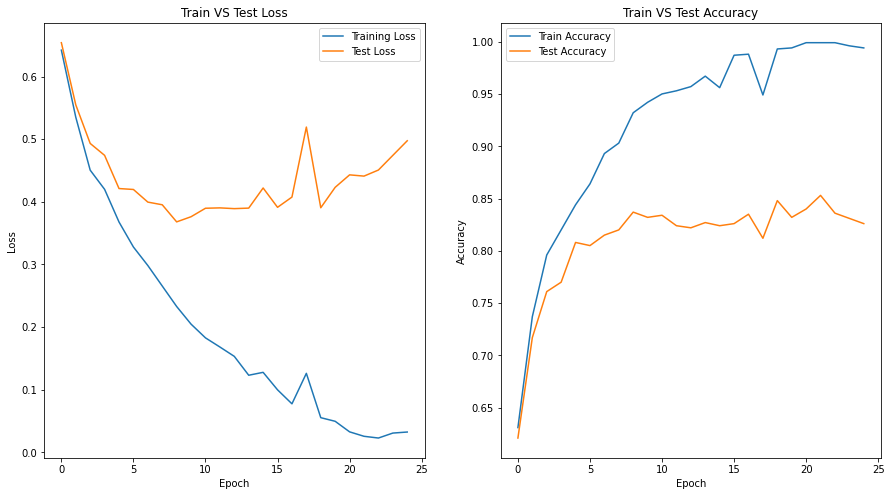

In [9]:
# train the model
my_model.trainer(train_input, train_target,test_input, test_target)

In [10]:
# output the total number of parameters
print("The total number of the parameters is: %d" % (sum(p.numel() for p in my_model.parameters())))

The total number of the parameters is: 166402


Epoch: 001/025 | Batch 000/1000 | Loss: 4.069934
Epoch: 001/025 | Batch 050/1000 | Loss: 62.091835
Epoch: 001/025 | Batch 100/1000 | Loss: 30.204578
Epoch: 001/025 | Batch 150/1000 | Loss: 18.551281
Epoch: 001/025 | Batch 200/1000 | Loss: 20.040421
Epoch: 001/025 | Batch 250/1000 | Loss: 11.722370
Epoch: 001/025 | Batch 300/1000 | Loss: 7.328938
Epoch: 001/025 | Batch 350/1000 | Loss: 3.672340
Epoch: 001/025 | Batch 400/1000 | Loss: 3.106340
Epoch: 001/025 | Batch 450/1000 | Loss: 1.516738
Epoch: 001/025 | Batch 500/1000 | Loss: 1.447031
Epoch: 001/025 | Batch 550/1000 | Loss: 1.535155
Epoch: 001/025 | Batch 600/1000 | Loss: 1.337088
Epoch: 001/025 | Batch 650/1000 | Loss: 1.099002
Epoch: 001/025 | Batch 700/1000 | Loss: 0.990701
Epoch: 001/025 | Batch 750/1000 | Loss: 1.005846
Epoch: 001/025 | Batch 800/1000 | Loss: 0.821386
Epoch: 001/025 | Batch 850/1000 | Loss: 0.643318
Epoch: 001/025 | Batch 900/1000 | Loss: 0.753696
Epoch: 001/025 | Batch 950/1000 | Loss: 0.632838
Time elapsed: 0

Epoch: 009/025 | Batch 300/1000 | Loss: 0.334470
Epoch: 009/025 | Batch 350/1000 | Loss: 0.362911
Epoch: 009/025 | Batch 400/1000 | Loss: 0.263484
Epoch: 009/025 | Batch 450/1000 | Loss: 0.441228
Epoch: 009/025 | Batch 500/1000 | Loss: 0.392006
Epoch: 009/025 | Batch 550/1000 | Loss: 0.305454
Epoch: 009/025 | Batch 600/1000 | Loss: 0.308442
Epoch: 009/025 | Batch 650/1000 | Loss: 0.283987
Epoch: 009/025 | Batch 700/1000 | Loss: 0.283911
Epoch: 009/025 | Batch 750/1000 | Loss: 0.314641
Epoch: 009/025 | Batch 800/1000 | Loss: 0.344818
Epoch: 009/025 | Batch 850/1000 | Loss: 0.357664
Epoch: 009/025 | Batch 900/1000 | Loss: 0.347722
Epoch: 009/025 | Batch 950/1000 | Loss: 0.386443
Time elapsed: 0.24 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.293639
Epoch: 010/025 | Batch 050/1000 | Loss: 0.345562
Epoch: 010/025 | Batch 100/1000 | Loss: 0.296426
Epoch: 010/025 | Batch 150/1000 | Loss: 0.329007
Epoch: 010/025 | Batch 200/1000 | Loss: 0.304531
Epoch: 010/025 | Batch 250/1000 | Loss: 0.2966

Epoch: 017/025 | Batch 500/1000 | Loss: 0.242655
Epoch: 017/025 | Batch 550/1000 | Loss: 0.152861
Epoch: 017/025 | Batch 600/1000 | Loss: 0.139910
Epoch: 017/025 | Batch 650/1000 | Loss: 0.220681
Epoch: 017/025 | Batch 700/1000 | Loss: 0.237860
Epoch: 017/025 | Batch 750/1000 | Loss: 0.330028
Epoch: 017/025 | Batch 800/1000 | Loss: 0.167486
Epoch: 017/025 | Batch 850/1000 | Loss: 0.142967
Epoch: 017/025 | Batch 900/1000 | Loss: 0.167616
Epoch: 017/025 | Batch 950/1000 | Loss: 0.301957
Time elapsed: 0.51 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.194822
Epoch: 018/025 | Batch 050/1000 | Loss: 0.154885
Epoch: 018/025 | Batch 100/1000 | Loss: 0.250010
Epoch: 018/025 | Batch 150/1000 | Loss: 0.314278
Epoch: 018/025 | Batch 200/1000 | Loss: 0.199972
Epoch: 018/025 | Batch 250/1000 | Loss: 0.150999
Epoch: 018/025 | Batch 300/1000 | Loss: 0.300380
Epoch: 018/025 | Batch 350/1000 | Loss: 0.155689
Epoch: 018/025 | Batch 400/1000 | Loss: 0.188071
Epoch: 018/025 | Batch 450/1000 | Loss: 0.1839

Epoch: 025/025 | Batch 850/1000 | Loss: 0.165033
Epoch: 025/025 | Batch 900/1000 | Loss: 0.174856
Epoch: 025/025 | Batch 950/1000 | Loss: 0.249402
Time elapsed: 0.76 min
Total Training Time: 0.78 min
Epoch: 001/025 | Batch 000/1000 | Loss: 2.646430
Epoch: 001/025 | Batch 050/1000 | Loss: 24.744579
Epoch: 001/025 | Batch 100/1000 | Loss: 22.638767
Epoch: 001/025 | Batch 150/1000 | Loss: 12.886582
Epoch: 001/025 | Batch 200/1000 | Loss: 4.126137
Epoch: 001/025 | Batch 250/1000 | Loss: 7.499882
Epoch: 001/025 | Batch 300/1000 | Loss: 5.789307
Epoch: 001/025 | Batch 350/1000 | Loss: 4.007542
Epoch: 001/025 | Batch 400/1000 | Loss: 1.458265
Epoch: 001/025 | Batch 450/1000 | Loss: 1.932586
Epoch: 001/025 | Batch 500/1000 | Loss: 2.156044
Epoch: 001/025 | Batch 550/1000 | Loss: 0.797131
Epoch: 001/025 | Batch 600/1000 | Loss: 0.900972
Epoch: 001/025 | Batch 650/1000 | Loss: 1.009748
Epoch: 001/025 | Batch 700/1000 | Loss: 1.457177
Epoch: 001/025 | Batch 750/1000 | Loss: 1.107920
Epoch: 001/02

Epoch: 009/025 | Batch 000/1000 | Loss: 0.362738
Epoch: 009/025 | Batch 050/1000 | Loss: 0.337485
Epoch: 009/025 | Batch 100/1000 | Loss: 0.393831
Epoch: 009/025 | Batch 150/1000 | Loss: 0.310124
Epoch: 009/025 | Batch 200/1000 | Loss: 0.261950
Epoch: 009/025 | Batch 250/1000 | Loss: 0.420340
Epoch: 009/025 | Batch 300/1000 | Loss: 0.338418
Epoch: 009/025 | Batch 350/1000 | Loss: 0.261753
Epoch: 009/025 | Batch 400/1000 | Loss: 0.274254
Epoch: 009/025 | Batch 450/1000 | Loss: 0.261475
Epoch: 009/025 | Batch 500/1000 | Loss: 0.404620
Epoch: 009/025 | Batch 550/1000 | Loss: 0.363502
Epoch: 009/025 | Batch 600/1000 | Loss: 0.355831
Epoch: 009/025 | Batch 650/1000 | Loss: 0.272148
Epoch: 009/025 | Batch 700/1000 | Loss: 0.389006
Epoch: 009/025 | Batch 750/1000 | Loss: 0.328163
Epoch: 009/025 | Batch 800/1000 | Loss: 0.300166
Epoch: 009/025 | Batch 850/1000 | Loss: 0.404057
Epoch: 009/025 | Batch 900/1000 | Loss: 0.291406
Epoch: 009/025 | Batch 950/1000 | Loss: 0.349257
Time elapsed: 0.26 m

Epoch: 017/025 | Batch 250/1000 | Loss: 0.144589
Epoch: 017/025 | Batch 300/1000 | Loss: 0.177432
Epoch: 017/025 | Batch 350/1000 | Loss: 0.159913
Epoch: 017/025 | Batch 400/1000 | Loss: 0.165476
Epoch: 017/025 | Batch 450/1000 | Loss: 0.232172
Epoch: 017/025 | Batch 500/1000 | Loss: 0.246310
Epoch: 017/025 | Batch 550/1000 | Loss: 0.187178
Epoch: 017/025 | Batch 600/1000 | Loss: 0.204129
Epoch: 017/025 | Batch 650/1000 | Loss: 0.187330
Epoch: 017/025 | Batch 700/1000 | Loss: 0.196476
Epoch: 017/025 | Batch 750/1000 | Loss: 0.179590
Epoch: 017/025 | Batch 800/1000 | Loss: 0.125123
Epoch: 017/025 | Batch 850/1000 | Loss: 0.172692
Epoch: 017/025 | Batch 900/1000 | Loss: 0.194641
Epoch: 017/025 | Batch 950/1000 | Loss: 0.202178
Time elapsed: 0.48 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.137478
Epoch: 018/025 | Batch 050/1000 | Loss: 0.192174
Epoch: 018/025 | Batch 100/1000 | Loss: 0.182703
Epoch: 018/025 | Batch 150/1000 | Loss: 0.220630
Epoch: 018/025 | Batch 200/1000 | Loss: 0.2106

Epoch: 025/025 | Batch 500/1000 | Loss: 0.222353
Epoch: 025/025 | Batch 550/1000 | Loss: 0.167985
Epoch: 025/025 | Batch 600/1000 | Loss: 0.227212
Epoch: 025/025 | Batch 650/1000 | Loss: 0.221696
Epoch: 025/025 | Batch 700/1000 | Loss: 0.075445
Epoch: 025/025 | Batch 750/1000 | Loss: 0.198607
Epoch: 025/025 | Batch 800/1000 | Loss: 0.232308
Epoch: 025/025 | Batch 850/1000 | Loss: 0.199613
Epoch: 025/025 | Batch 900/1000 | Loss: 0.181041
Epoch: 025/025 | Batch 950/1000 | Loss: 0.143876
Time elapsed: 0.77 min
Total Training Time: 0.79 min
Epoch: 001/025 | Batch 000/1000 | Loss: 4.917413
Epoch: 001/025 | Batch 050/1000 | Loss: 50.434917
Epoch: 001/025 | Batch 100/1000 | Loss: 23.184961
Epoch: 001/025 | Batch 150/1000 | Loss: 18.874189
Epoch: 001/025 | Batch 200/1000 | Loss: 2.589931
Epoch: 001/025 | Batch 250/1000 | Loss: 4.772719
Epoch: 001/025 | Batch 300/1000 | Loss: 5.115772
Epoch: 001/025 | Batch 350/1000 | Loss: 1.840748
Epoch: 001/025 | Batch 400/1000 | Loss: 1.376623
Epoch: 001/02

Epoch: 008/025 | Batch 750/1000 | Loss: 0.273560
Epoch: 008/025 | Batch 800/1000 | Loss: 0.432686
Epoch: 008/025 | Batch 850/1000 | Loss: 0.321981
Epoch: 008/025 | Batch 900/1000 | Loss: 0.330596
Epoch: 008/025 | Batch 950/1000 | Loss: 0.441590
Time elapsed: 0.23 min
Epoch: 009/025 | Batch 000/1000 | Loss: 0.385293
Epoch: 009/025 | Batch 050/1000 | Loss: 0.432313
Epoch: 009/025 | Batch 100/1000 | Loss: 0.315739
Epoch: 009/025 | Batch 150/1000 | Loss: 0.445638
Epoch: 009/025 | Batch 200/1000 | Loss: 0.311972
Epoch: 009/025 | Batch 250/1000 | Loss: 0.392273
Epoch: 009/025 | Batch 300/1000 | Loss: 0.471728
Epoch: 009/025 | Batch 350/1000 | Loss: 0.401937
Epoch: 009/025 | Batch 400/1000 | Loss: 0.358274
Epoch: 009/025 | Batch 450/1000 | Loss: 0.362963
Epoch: 009/025 | Batch 500/1000 | Loss: 0.486666
Epoch: 009/025 | Batch 550/1000 | Loss: 0.366326
Epoch: 009/025 | Batch 600/1000 | Loss: 0.381653
Epoch: 009/025 | Batch 650/1000 | Loss: 0.496208
Epoch: 009/025 | Batch 700/1000 | Loss: 0.3024

Epoch: 016/025 | Batch 950/1000 | Loss: 0.249663
Time elapsed: 0.47 min
Epoch: 017/025 | Batch 000/1000 | Loss: 0.211599
Epoch: 017/025 | Batch 050/1000 | Loss: 0.236263
Epoch: 017/025 | Batch 100/1000 | Loss: 0.358278
Epoch: 017/025 | Batch 150/1000 | Loss: 0.411525
Epoch: 017/025 | Batch 200/1000 | Loss: 0.165665
Epoch: 017/025 | Batch 250/1000 | Loss: 0.301353
Epoch: 017/025 | Batch 300/1000 | Loss: 0.166042
Epoch: 017/025 | Batch 350/1000 | Loss: 0.213964
Epoch: 017/025 | Batch 400/1000 | Loss: 0.328314
Epoch: 017/025 | Batch 450/1000 | Loss: 0.213909
Epoch: 017/025 | Batch 500/1000 | Loss: 0.348646
Epoch: 017/025 | Batch 550/1000 | Loss: 0.232486
Epoch: 017/025 | Batch 600/1000 | Loss: 0.359718
Epoch: 017/025 | Batch 650/1000 | Loss: 0.196528
Epoch: 017/025 | Batch 700/1000 | Loss: 0.262902
Epoch: 017/025 | Batch 750/1000 | Loss: 0.292425
Epoch: 017/025 | Batch 800/1000 | Loss: 0.281229
Epoch: 017/025 | Batch 850/1000 | Loss: 0.284638
Epoch: 017/025 | Batch 900/1000 | Loss: 0.1902

Epoch: 025/025 | Batch 250/1000 | Loss: 0.214457
Epoch: 025/025 | Batch 300/1000 | Loss: 0.244128
Epoch: 025/025 | Batch 350/1000 | Loss: 0.154356
Epoch: 025/025 | Batch 400/1000 | Loss: 0.260174
Epoch: 025/025 | Batch 450/1000 | Loss: 0.225339
Epoch: 025/025 | Batch 500/1000 | Loss: 0.282367
Epoch: 025/025 | Batch 550/1000 | Loss: 0.178978
Epoch: 025/025 | Batch 600/1000 | Loss: 0.286129
Epoch: 025/025 | Batch 650/1000 | Loss: 0.269901
Epoch: 025/025 | Batch 700/1000 | Loss: 0.155991
Epoch: 025/025 | Batch 750/1000 | Loss: 0.148338
Epoch: 025/025 | Batch 800/1000 | Loss: 0.120129
Epoch: 025/025 | Batch 850/1000 | Loss: 0.183258
Epoch: 025/025 | Batch 900/1000 | Loss: 0.244619
Epoch: 025/025 | Batch 950/1000 | Loss: 0.213598
Time elapsed: 0.75 min
Total Training Time: 0.76 min
Epoch: 001/025 | Batch 000/1000 | Loss: 5.593976
Epoch: 001/025 | Batch 050/1000 | Loss: 18.173378
Epoch: 001/025 | Batch 100/1000 | Loss: 16.594027
Epoch: 001/025 | Batch 150/1000 | Loss: 5.865286
Epoch: 001/025

Epoch: 008/025 | Batch 550/1000 | Loss: 0.300357
Epoch: 008/025 | Batch 600/1000 | Loss: 0.376149
Epoch: 008/025 | Batch 650/1000 | Loss: 0.378568
Epoch: 008/025 | Batch 700/1000 | Loss: 0.414063
Epoch: 008/025 | Batch 750/1000 | Loss: 0.292736
Epoch: 008/025 | Batch 800/1000 | Loss: 0.309169
Epoch: 008/025 | Batch 850/1000 | Loss: 0.390351
Epoch: 008/025 | Batch 900/1000 | Loss: 0.439904
Epoch: 008/025 | Batch 950/1000 | Loss: 0.358138
Time elapsed: 0.23 min
Epoch: 009/025 | Batch 000/1000 | Loss: 0.369608
Epoch: 009/025 | Batch 050/1000 | Loss: 0.383784
Epoch: 009/025 | Batch 100/1000 | Loss: 0.238423
Epoch: 009/025 | Batch 150/1000 | Loss: 0.272682
Epoch: 009/025 | Batch 200/1000 | Loss: 0.288977
Epoch: 009/025 | Batch 250/1000 | Loss: 0.375424
Epoch: 009/025 | Batch 300/1000 | Loss: 0.303182
Epoch: 009/025 | Batch 350/1000 | Loss: 0.219530
Epoch: 009/025 | Batch 400/1000 | Loss: 0.299112
Epoch: 009/025 | Batch 450/1000 | Loss: 0.292758
Epoch: 009/025 | Batch 500/1000 | Loss: 0.3609

Epoch: 016/025 | Batch 750/1000 | Loss: 0.185566
Epoch: 016/025 | Batch 800/1000 | Loss: 0.270034
Epoch: 016/025 | Batch 850/1000 | Loss: 0.207091
Epoch: 016/025 | Batch 900/1000 | Loss: 0.244150
Epoch: 016/025 | Batch 950/1000 | Loss: 0.159621
Time elapsed: 0.50 min
Epoch: 017/025 | Batch 000/1000 | Loss: 0.234060
Epoch: 017/025 | Batch 050/1000 | Loss: 0.225558
Epoch: 017/025 | Batch 100/1000 | Loss: 0.277930
Epoch: 017/025 | Batch 150/1000 | Loss: 0.233664
Epoch: 017/025 | Batch 200/1000 | Loss: 0.172658
Epoch: 017/025 | Batch 250/1000 | Loss: 0.116778
Epoch: 017/025 | Batch 300/1000 | Loss: 0.225448
Epoch: 017/025 | Batch 350/1000 | Loss: 0.161981
Epoch: 017/025 | Batch 400/1000 | Loss: 0.171853
Epoch: 017/025 | Batch 450/1000 | Loss: 0.236583
Epoch: 017/025 | Batch 500/1000 | Loss: 0.179958
Epoch: 017/025 | Batch 550/1000 | Loss: 0.305006
Epoch: 017/025 | Batch 600/1000 | Loss: 0.259664
Epoch: 017/025 | Batch 650/1000 | Loss: 0.206926
Epoch: 017/025 | Batch 700/1000 | Loss: 0.2077

Epoch: 025/025 | Batch 000/1000 | Loss: 0.188164
Epoch: 025/025 | Batch 050/1000 | Loss: 0.202543
Epoch: 025/025 | Batch 100/1000 | Loss: 0.223957
Epoch: 025/025 | Batch 150/1000 | Loss: 0.260583
Epoch: 025/025 | Batch 200/1000 | Loss: 0.208867
Epoch: 025/025 | Batch 250/1000 | Loss: 0.174620
Epoch: 025/025 | Batch 300/1000 | Loss: 0.321913
Epoch: 025/025 | Batch 350/1000 | Loss: 0.241824
Epoch: 025/025 | Batch 400/1000 | Loss: 0.184176
Epoch: 025/025 | Batch 450/1000 | Loss: 0.223498
Epoch: 025/025 | Batch 500/1000 | Loss: 0.263903
Epoch: 025/025 | Batch 550/1000 | Loss: 0.203314
Epoch: 025/025 | Batch 600/1000 | Loss: 0.206704
Epoch: 025/025 | Batch 650/1000 | Loss: 0.226054
Epoch: 025/025 | Batch 700/1000 | Loss: 0.258215
Epoch: 025/025 | Batch 750/1000 | Loss: 0.253161
Epoch: 025/025 | Batch 800/1000 | Loss: 0.222050
Epoch: 025/025 | Batch 850/1000 | Loss: 0.215199
Epoch: 025/025 | Batch 900/1000 | Loss: 0.246514
Epoch: 025/025 | Batch 950/1000 | Loss: 0.218270
Time elapsed: 0.77 m

Epoch: 008/025 | Batch 250/1000 | Loss: 0.295418
Epoch: 008/025 | Batch 300/1000 | Loss: 0.415052
Epoch: 008/025 | Batch 350/1000 | Loss: 0.390237
Epoch: 008/025 | Batch 400/1000 | Loss: 0.377137
Epoch: 008/025 | Batch 450/1000 | Loss: 0.302604
Epoch: 008/025 | Batch 500/1000 | Loss: 0.281979
Epoch: 008/025 | Batch 550/1000 | Loss: 0.378641
Epoch: 008/025 | Batch 600/1000 | Loss: 0.396871
Epoch: 008/025 | Batch 650/1000 | Loss: 0.355716
Epoch: 008/025 | Batch 700/1000 | Loss: 0.246375
Epoch: 008/025 | Batch 750/1000 | Loss: 0.318737
Epoch: 008/025 | Batch 800/1000 | Loss: 0.296005
Epoch: 008/025 | Batch 850/1000 | Loss: 0.318264
Epoch: 008/025 | Batch 900/1000 | Loss: 0.443672
Epoch: 008/025 | Batch 950/1000 | Loss: 0.236614
Time elapsed: 0.24 min
Epoch: 009/025 | Batch 000/1000 | Loss: 0.397135
Epoch: 009/025 | Batch 050/1000 | Loss: 0.296932
Epoch: 009/025 | Batch 100/1000 | Loss: 0.375140
Epoch: 009/025 | Batch 150/1000 | Loss: 0.421985
Epoch: 009/025 | Batch 200/1000 | Loss: 0.3368

Epoch: 016/025 | Batch 500/1000 | Loss: 0.237691
Epoch: 016/025 | Batch 550/1000 | Loss: 0.256175
Epoch: 016/025 | Batch 600/1000 | Loss: 0.322414
Epoch: 016/025 | Batch 650/1000 | Loss: 0.194173
Epoch: 016/025 | Batch 700/1000 | Loss: 0.174225
Epoch: 016/025 | Batch 750/1000 | Loss: 0.225161
Epoch: 016/025 | Batch 800/1000 | Loss: 0.271897
Epoch: 016/025 | Batch 850/1000 | Loss: 0.188343
Epoch: 016/025 | Batch 900/1000 | Loss: 0.167551
Epoch: 016/025 | Batch 950/1000 | Loss: 0.235242
Time elapsed: 0.49 min
Epoch: 017/025 | Batch 000/1000 | Loss: 0.266163
Epoch: 017/025 | Batch 050/1000 | Loss: 0.254194
Epoch: 017/025 | Batch 100/1000 | Loss: 0.272961
Epoch: 017/025 | Batch 150/1000 | Loss: 0.204245
Epoch: 017/025 | Batch 200/1000 | Loss: 0.180862
Epoch: 017/025 | Batch 250/1000 | Loss: 0.129393
Epoch: 017/025 | Batch 300/1000 | Loss: 0.207412
Epoch: 017/025 | Batch 350/1000 | Loss: 0.193332
Epoch: 017/025 | Batch 400/1000 | Loss: 0.234934
Epoch: 017/025 | Batch 450/1000 | Loss: 0.2149

Epoch: 024/025 | Batch 750/1000 | Loss: 0.193956
Epoch: 024/025 | Batch 800/1000 | Loss: 0.222787
Epoch: 024/025 | Batch 850/1000 | Loss: 0.193139
Epoch: 024/025 | Batch 900/1000 | Loss: 0.223094
Epoch: 024/025 | Batch 950/1000 | Loss: 0.184039
Time elapsed: 0.76 min
Epoch: 025/025 | Batch 000/1000 | Loss: 0.239744
Epoch: 025/025 | Batch 050/1000 | Loss: 0.188264
Epoch: 025/025 | Batch 100/1000 | Loss: 0.262220
Epoch: 025/025 | Batch 150/1000 | Loss: 0.240864
Epoch: 025/025 | Batch 200/1000 | Loss: 0.224284
Epoch: 025/025 | Batch 250/1000 | Loss: 0.184596
Epoch: 025/025 | Batch 300/1000 | Loss: 0.184372
Epoch: 025/025 | Batch 350/1000 | Loss: 0.279954
Epoch: 025/025 | Batch 400/1000 | Loss: 0.245063
Epoch: 025/025 | Batch 450/1000 | Loss: 0.120180
Epoch: 025/025 | Batch 500/1000 | Loss: 0.243859
Epoch: 025/025 | Batch 550/1000 | Loss: 0.187908
Epoch: 025/025 | Batch 600/1000 | Loss: 0.252978
Epoch: 025/025 | Batch 650/1000 | Loss: 0.164338
Epoch: 025/025 | Batch 700/1000 | Loss: 0.2269

Epoch: 008/025 | Batch 000/1000 | Loss: 0.267374
Epoch: 008/025 | Batch 050/1000 | Loss: 0.291122
Epoch: 008/025 | Batch 100/1000 | Loss: 0.247753
Epoch: 008/025 | Batch 150/1000 | Loss: 0.332636
Epoch: 008/025 | Batch 200/1000 | Loss: 0.362459
Epoch: 008/025 | Batch 250/1000 | Loss: 0.279586
Epoch: 008/025 | Batch 300/1000 | Loss: 0.292850
Epoch: 008/025 | Batch 350/1000 | Loss: 0.392885
Epoch: 008/025 | Batch 400/1000 | Loss: 0.366805
Epoch: 008/025 | Batch 450/1000 | Loss: 0.317632
Epoch: 008/025 | Batch 500/1000 | Loss: 0.281252
Epoch: 008/025 | Batch 550/1000 | Loss: 0.401452
Epoch: 008/025 | Batch 600/1000 | Loss: 0.315505
Epoch: 008/025 | Batch 650/1000 | Loss: 0.387685
Epoch: 008/025 | Batch 700/1000 | Loss: 0.360710
Epoch: 008/025 | Batch 750/1000 | Loss: 0.355146
Epoch: 008/025 | Batch 800/1000 | Loss: 0.242646
Epoch: 008/025 | Batch 850/1000 | Loss: 0.309127
Epoch: 008/025 | Batch 900/1000 | Loss: 0.393279
Epoch: 008/025 | Batch 950/1000 | Loss: 0.349223
Time elapsed: 0.23 m

Epoch: 016/025 | Batch 300/1000 | Loss: 0.182569
Epoch: 016/025 | Batch 350/1000 | Loss: 0.217007
Epoch: 016/025 | Batch 400/1000 | Loss: 0.238340
Epoch: 016/025 | Batch 450/1000 | Loss: 0.232513
Epoch: 016/025 | Batch 500/1000 | Loss: 0.179829
Epoch: 016/025 | Batch 550/1000 | Loss: 0.246101
Epoch: 016/025 | Batch 600/1000 | Loss: 0.233615
Epoch: 016/025 | Batch 650/1000 | Loss: 0.239517
Epoch: 016/025 | Batch 700/1000 | Loss: 0.139747
Epoch: 016/025 | Batch 750/1000 | Loss: 0.286489
Epoch: 016/025 | Batch 800/1000 | Loss: 0.174929
Epoch: 016/025 | Batch 850/1000 | Loss: 0.166253
Epoch: 016/025 | Batch 900/1000 | Loss: 0.237355
Epoch: 016/025 | Batch 950/1000 | Loss: 0.165903
Time elapsed: 0.46 min
Epoch: 017/025 | Batch 000/1000 | Loss: 0.204164
Epoch: 017/025 | Batch 050/1000 | Loss: 0.195629
Epoch: 017/025 | Batch 100/1000 | Loss: 0.226853
Epoch: 017/025 | Batch 150/1000 | Loss: 0.163983
Epoch: 017/025 | Batch 200/1000 | Loss: 0.158152
Epoch: 017/025 | Batch 250/1000 | Loss: 0.2083

Epoch: 024/025 | Batch 700/1000 | Loss: 0.278538
Epoch: 024/025 | Batch 750/1000 | Loss: 0.189772
Epoch: 024/025 | Batch 800/1000 | Loss: 0.173365
Epoch: 024/025 | Batch 850/1000 | Loss: 0.197264
Epoch: 024/025 | Batch 900/1000 | Loss: 0.247031
Epoch: 024/025 | Batch 950/1000 | Loss: 0.226495
Time elapsed: 0.62 min
Epoch: 025/025 | Batch 000/1000 | Loss: 0.130999
Epoch: 025/025 | Batch 050/1000 | Loss: 0.225799
Epoch: 025/025 | Batch 100/1000 | Loss: 0.185731
Epoch: 025/025 | Batch 150/1000 | Loss: 0.187452
Epoch: 025/025 | Batch 200/1000 | Loss: 0.153772
Epoch: 025/025 | Batch 250/1000 | Loss: 0.141424
Epoch: 025/025 | Batch 300/1000 | Loss: 0.149970
Epoch: 025/025 | Batch 350/1000 | Loss: 0.185363
Epoch: 025/025 | Batch 400/1000 | Loss: 0.130364
Epoch: 025/025 | Batch 450/1000 | Loss: 0.141492
Epoch: 025/025 | Batch 500/1000 | Loss: 0.175114
Epoch: 025/025 | Batch 550/1000 | Loss: 0.134680
Epoch: 025/025 | Batch 600/1000 | Loss: 0.207242
Epoch: 025/025 | Batch 650/1000 | Loss: 0.2149

Epoch: 008/025 | Batch 000/1000 | Loss: 0.432492
Epoch: 008/025 | Batch 050/1000 | Loss: 0.472946
Epoch: 008/025 | Batch 100/1000 | Loss: 0.522024
Epoch: 008/025 | Batch 150/1000 | Loss: 0.340757
Epoch: 008/025 | Batch 200/1000 | Loss: 0.264252
Epoch: 008/025 | Batch 250/1000 | Loss: 0.309277
Epoch: 008/025 | Batch 300/1000 | Loss: 0.384039
Epoch: 008/025 | Batch 350/1000 | Loss: 0.427974
Epoch: 008/025 | Batch 400/1000 | Loss: 0.485251
Epoch: 008/025 | Batch 450/1000 | Loss: 0.401400
Epoch: 008/025 | Batch 500/1000 | Loss: 0.401891
Epoch: 008/025 | Batch 550/1000 | Loss: 0.398191
Epoch: 008/025 | Batch 600/1000 | Loss: 0.355646
Epoch: 008/025 | Batch 650/1000 | Loss: 0.294453
Epoch: 008/025 | Batch 700/1000 | Loss: 0.385175
Epoch: 008/025 | Batch 750/1000 | Loss: 0.409397
Epoch: 008/025 | Batch 800/1000 | Loss: 0.314164
Epoch: 008/025 | Batch 850/1000 | Loss: 0.365533
Epoch: 008/025 | Batch 900/1000 | Loss: 0.249984
Epoch: 008/025 | Batch 950/1000 | Loss: 0.305117
Time elapsed: 0.16 m

Epoch: 016/025 | Batch 350/1000 | Loss: 0.226085
Epoch: 016/025 | Batch 400/1000 | Loss: 0.249919
Epoch: 016/025 | Batch 450/1000 | Loss: 0.246422
Epoch: 016/025 | Batch 500/1000 | Loss: 0.249628
Epoch: 016/025 | Batch 550/1000 | Loss: 0.263177
Epoch: 016/025 | Batch 600/1000 | Loss: 0.171273
Epoch: 016/025 | Batch 650/1000 | Loss: 0.168458
Epoch: 016/025 | Batch 700/1000 | Loss: 0.234064
Epoch: 016/025 | Batch 750/1000 | Loss: 0.122967
Epoch: 016/025 | Batch 800/1000 | Loss: 0.170263
Epoch: 016/025 | Batch 850/1000 | Loss: 0.297699
Epoch: 016/025 | Batch 900/1000 | Loss: 0.256605
Epoch: 016/025 | Batch 950/1000 | Loss: 0.283951
Time elapsed: 0.32 min
Epoch: 017/025 | Batch 000/1000 | Loss: 0.170197
Epoch: 017/025 | Batch 050/1000 | Loss: 0.254672
Epoch: 017/025 | Batch 100/1000 | Loss: 0.278618
Epoch: 017/025 | Batch 150/1000 | Loss: 0.210463
Epoch: 017/025 | Batch 200/1000 | Loss: 0.182673
Epoch: 017/025 | Batch 250/1000 | Loss: 0.098251
Epoch: 017/025 | Batch 300/1000 | Loss: 0.1948

Epoch: 024/025 | Batch 700/1000 | Loss: 0.213331
Epoch: 024/025 | Batch 750/1000 | Loss: 0.211463
Epoch: 024/025 | Batch 800/1000 | Loss: 0.238571
Epoch: 024/025 | Batch 850/1000 | Loss: 0.115655
Epoch: 024/025 | Batch 900/1000 | Loss: 0.190616
Epoch: 024/025 | Batch 950/1000 | Loss: 0.160877
Time elapsed: 0.50 min
Epoch: 025/025 | Batch 000/1000 | Loss: 0.134798
Epoch: 025/025 | Batch 050/1000 | Loss: 0.173539
Epoch: 025/025 | Batch 100/1000 | Loss: 0.151253
Epoch: 025/025 | Batch 150/1000 | Loss: 0.099730
Epoch: 025/025 | Batch 200/1000 | Loss: 0.187678
Epoch: 025/025 | Batch 250/1000 | Loss: 0.191612
Epoch: 025/025 | Batch 300/1000 | Loss: 0.131190
Epoch: 025/025 | Batch 350/1000 | Loss: 0.212524
Epoch: 025/025 | Batch 400/1000 | Loss: 0.200772
Epoch: 025/025 | Batch 450/1000 | Loss: 0.210400
Epoch: 025/025 | Batch 500/1000 | Loss: 0.214710
Epoch: 025/025 | Batch 550/1000 | Loss: 0.263835
Epoch: 025/025 | Batch 600/1000 | Loss: 0.172658
Epoch: 025/025 | Batch 650/1000 | Loss: 0.1054

Epoch: 008/025 | Batch 000/1000 | Loss: 0.372250
Epoch: 008/025 | Batch 050/1000 | Loss: 0.379211
Epoch: 008/025 | Batch 100/1000 | Loss: 0.454875
Epoch: 008/025 | Batch 150/1000 | Loss: 0.342329
Epoch: 008/025 | Batch 200/1000 | Loss: 0.368039
Epoch: 008/025 | Batch 250/1000 | Loss: 0.357209
Epoch: 008/025 | Batch 300/1000 | Loss: 0.402230
Epoch: 008/025 | Batch 350/1000 | Loss: 0.345134
Epoch: 008/025 | Batch 400/1000 | Loss: 0.376521
Epoch: 008/025 | Batch 450/1000 | Loss: 0.424760
Epoch: 008/025 | Batch 500/1000 | Loss: 0.404879
Epoch: 008/025 | Batch 550/1000 | Loss: 0.379022
Epoch: 008/025 | Batch 600/1000 | Loss: 0.418150
Epoch: 008/025 | Batch 650/1000 | Loss: 0.427237
Epoch: 008/025 | Batch 700/1000 | Loss: 0.305417
Epoch: 008/025 | Batch 750/1000 | Loss: 0.457548
Epoch: 008/025 | Batch 800/1000 | Loss: 0.504154
Epoch: 008/025 | Batch 850/1000 | Loss: 0.456809
Epoch: 008/025 | Batch 900/1000 | Loss: 0.413874
Epoch: 008/025 | Batch 950/1000 | Loss: 0.471192
Time elapsed: 0.17 m

Epoch: 016/025 | Batch 400/1000 | Loss: 0.307329
Epoch: 016/025 | Batch 450/1000 | Loss: 0.200789
Epoch: 016/025 | Batch 500/1000 | Loss: 0.299452
Epoch: 016/025 | Batch 550/1000 | Loss: 0.308030
Epoch: 016/025 | Batch 600/1000 | Loss: 0.258171
Epoch: 016/025 | Batch 650/1000 | Loss: 0.173170
Epoch: 016/025 | Batch 700/1000 | Loss: 0.220322
Epoch: 016/025 | Batch 750/1000 | Loss: 0.246110
Epoch: 016/025 | Batch 800/1000 | Loss: 0.255050
Epoch: 016/025 | Batch 850/1000 | Loss: 0.191245
Epoch: 016/025 | Batch 900/1000 | Loss: 0.302285
Epoch: 016/025 | Batch 950/1000 | Loss: 0.288005
Time elapsed: 0.35 min
Epoch: 017/025 | Batch 000/1000 | Loss: 0.228105
Epoch: 017/025 | Batch 050/1000 | Loss: 0.220104
Epoch: 017/025 | Batch 100/1000 | Loss: 0.283402
Epoch: 017/025 | Batch 150/1000 | Loss: 0.322341
Epoch: 017/025 | Batch 200/1000 | Loss: 0.225203
Epoch: 017/025 | Batch 250/1000 | Loss: 0.235315
Epoch: 017/025 | Batch 300/1000 | Loss: 0.203555
Epoch: 017/025 | Batch 350/1000 | Loss: 0.1965

Epoch: 024/025 | Batch 750/1000 | Loss: 0.181637
Epoch: 024/025 | Batch 800/1000 | Loss: 0.165258
Epoch: 024/025 | Batch 850/1000 | Loss: 0.230562
Epoch: 024/025 | Batch 900/1000 | Loss: 0.250410
Epoch: 024/025 | Batch 950/1000 | Loss: 0.161771
Time elapsed: 0.52 min
Epoch: 025/025 | Batch 000/1000 | Loss: 0.185624
Epoch: 025/025 | Batch 050/1000 | Loss: 0.192746
Epoch: 025/025 | Batch 100/1000 | Loss: 0.211982
Epoch: 025/025 | Batch 150/1000 | Loss: 0.226546
Epoch: 025/025 | Batch 200/1000 | Loss: 0.167510
Epoch: 025/025 | Batch 250/1000 | Loss: 0.260961
Epoch: 025/025 | Batch 300/1000 | Loss: 0.199296
Epoch: 025/025 | Batch 350/1000 | Loss: 0.200546
Epoch: 025/025 | Batch 400/1000 | Loss: 0.211894
Epoch: 025/025 | Batch 450/1000 | Loss: 0.231265
Epoch: 025/025 | Batch 500/1000 | Loss: 0.276962
Epoch: 025/025 | Batch 550/1000 | Loss: 0.229127
Epoch: 025/025 | Batch 600/1000 | Loss: 0.234801
Epoch: 025/025 | Batch 650/1000 | Loss: 0.167499
Epoch: 025/025 | Batch 700/1000 | Loss: 0.2035

Epoch: 008/025 | Batch 000/1000 | Loss: 0.348878
Epoch: 008/025 | Batch 050/1000 | Loss: 0.330812
Epoch: 008/025 | Batch 100/1000 | Loss: 0.326801
Epoch: 008/025 | Batch 150/1000 | Loss: 0.379948
Epoch: 008/025 | Batch 200/1000 | Loss: 0.461339
Epoch: 008/025 | Batch 250/1000 | Loss: 0.303152
Epoch: 008/025 | Batch 300/1000 | Loss: 0.439565
Epoch: 008/025 | Batch 350/1000 | Loss: 0.379574
Epoch: 008/025 | Batch 400/1000 | Loss: 0.237709
Epoch: 008/025 | Batch 450/1000 | Loss: 0.420347
Epoch: 008/025 | Batch 500/1000 | Loss: 0.519813
Epoch: 008/025 | Batch 550/1000 | Loss: 0.407150
Epoch: 008/025 | Batch 600/1000 | Loss: 0.369501
Epoch: 008/025 | Batch 650/1000 | Loss: 0.373768
Epoch: 008/025 | Batch 700/1000 | Loss: 0.423778
Epoch: 008/025 | Batch 750/1000 | Loss: 0.432787
Epoch: 008/025 | Batch 800/1000 | Loss: 0.344505
Epoch: 008/025 | Batch 850/1000 | Loss: 0.332344
Epoch: 008/025 | Batch 900/1000 | Loss: 0.338480
Epoch: 008/025 | Batch 950/1000 | Loss: 0.567743
Time elapsed: 0.16 m

Epoch: 016/025 | Batch 300/1000 | Loss: 0.247942
Epoch: 016/025 | Batch 350/1000 | Loss: 0.218782
Epoch: 016/025 | Batch 400/1000 | Loss: 0.199537
Epoch: 016/025 | Batch 450/1000 | Loss: 0.258283
Epoch: 016/025 | Batch 500/1000 | Loss: 0.208932
Epoch: 016/025 | Batch 550/1000 | Loss: 0.171064
Epoch: 016/025 | Batch 600/1000 | Loss: 0.227759
Epoch: 016/025 | Batch 650/1000 | Loss: 0.235328
Epoch: 016/025 | Batch 700/1000 | Loss: 0.256680
Epoch: 016/025 | Batch 750/1000 | Loss: 0.219061
Epoch: 016/025 | Batch 800/1000 | Loss: 0.287453
Epoch: 016/025 | Batch 850/1000 | Loss: 0.252953
Epoch: 016/025 | Batch 900/1000 | Loss: 0.149929
Epoch: 016/025 | Batch 950/1000 | Loss: 0.281232
Time elapsed: 0.37 min
Epoch: 017/025 | Batch 000/1000 | Loss: 0.221500
Epoch: 017/025 | Batch 050/1000 | Loss: 0.360986
Epoch: 017/025 | Batch 100/1000 | Loss: 0.320118
Epoch: 017/025 | Batch 150/1000 | Loss: 0.286064
Epoch: 017/025 | Batch 200/1000 | Loss: 0.154280
Epoch: 017/025 | Batch 250/1000 | Loss: 0.1403

Epoch: 024/025 | Batch 800/1000 | Loss: 0.302003
Epoch: 024/025 | Batch 850/1000 | Loss: 0.172605
Epoch: 024/025 | Batch 900/1000 | Loss: 0.188083
Epoch: 024/025 | Batch 950/1000 | Loss: 0.161290
Time elapsed: 0.56 min
Epoch: 025/025 | Batch 000/1000 | Loss: 0.217750
Epoch: 025/025 | Batch 050/1000 | Loss: 0.262164
Epoch: 025/025 | Batch 100/1000 | Loss: 0.143741
Epoch: 025/025 | Batch 150/1000 | Loss: 0.109988
Epoch: 025/025 | Batch 200/1000 | Loss: 0.138759
Epoch: 025/025 | Batch 250/1000 | Loss: 0.260910
Epoch: 025/025 | Batch 300/1000 | Loss: 0.205497
Epoch: 025/025 | Batch 350/1000 | Loss: 0.168157
Epoch: 025/025 | Batch 400/1000 | Loss: 0.157797
Epoch: 025/025 | Batch 450/1000 | Loss: 0.179462
Epoch: 025/025 | Batch 500/1000 | Loss: 0.232084
Epoch: 025/025 | Batch 550/1000 | Loss: 0.215514
Epoch: 025/025 | Batch 600/1000 | Loss: 0.097001
Epoch: 025/025 | Batch 650/1000 | Loss: 0.161461
Epoch: 025/025 | Batch 700/1000 | Loss: 0.153409
Epoch: 025/025 | Batch 750/1000 | Loss: 0.2456

Epoch: 008/025 | Batch 000/1000 | Loss: 0.475416
Epoch: 008/025 | Batch 050/1000 | Loss: 0.405067
Epoch: 008/025 | Batch 100/1000 | Loss: 0.437302
Epoch: 008/025 | Batch 150/1000 | Loss: 0.349233
Epoch: 008/025 | Batch 200/1000 | Loss: 0.401612
Epoch: 008/025 | Batch 250/1000 | Loss: 0.384984
Epoch: 008/025 | Batch 300/1000 | Loss: 0.452179
Epoch: 008/025 | Batch 350/1000 | Loss: 0.461300
Epoch: 008/025 | Batch 400/1000 | Loss: 0.408620
Epoch: 008/025 | Batch 450/1000 | Loss: 0.403653
Epoch: 008/025 | Batch 500/1000 | Loss: 0.447746
Epoch: 008/025 | Batch 550/1000 | Loss: 0.469092
Epoch: 008/025 | Batch 600/1000 | Loss: 0.432774
Epoch: 008/025 | Batch 650/1000 | Loss: 0.366129
Epoch: 008/025 | Batch 700/1000 | Loss: 0.478528
Epoch: 008/025 | Batch 750/1000 | Loss: 0.413087
Epoch: 008/025 | Batch 800/1000 | Loss: 0.345709
Epoch: 008/025 | Batch 850/1000 | Loss: 0.515828
Epoch: 008/025 | Batch 900/1000 | Loss: 0.324928
Epoch: 008/025 | Batch 950/1000 | Loss: 0.439039
Time elapsed: 0.16 m

Epoch: 016/025 | Batch 350/1000 | Loss: 0.231564
Epoch: 016/025 | Batch 400/1000 | Loss: 0.219126
Epoch: 016/025 | Batch 450/1000 | Loss: 0.288986
Epoch: 016/025 | Batch 500/1000 | Loss: 0.227943
Epoch: 016/025 | Batch 550/1000 | Loss: 0.415361
Epoch: 016/025 | Batch 600/1000 | Loss: 0.240160
Epoch: 016/025 | Batch 650/1000 | Loss: 0.261604
Epoch: 016/025 | Batch 700/1000 | Loss: 0.205355
Epoch: 016/025 | Batch 750/1000 | Loss: 0.225092
Epoch: 016/025 | Batch 800/1000 | Loss: 0.260923
Epoch: 016/025 | Batch 850/1000 | Loss: 0.242813
Epoch: 016/025 | Batch 900/1000 | Loss: 0.142670
Epoch: 016/025 | Batch 950/1000 | Loss: 0.252457
Time elapsed: 0.33 min
Epoch: 017/025 | Batch 000/1000 | Loss: 0.392530
Epoch: 017/025 | Batch 050/1000 | Loss: 0.237951
Epoch: 017/025 | Batch 100/1000 | Loss: 0.200298
Epoch: 017/025 | Batch 150/1000 | Loss: 0.295240
Epoch: 017/025 | Batch 200/1000 | Loss: 0.242517
Epoch: 017/025 | Batch 250/1000 | Loss: 0.166481
Epoch: 017/025 | Batch 300/1000 | Loss: 0.2250

Epoch: 024/025 | Batch 700/1000 | Loss: 0.179232
Epoch: 024/025 | Batch 750/1000 | Loss: 0.175043
Epoch: 024/025 | Batch 800/1000 | Loss: 0.171072
Epoch: 024/025 | Batch 850/1000 | Loss: 0.264417
Epoch: 024/025 | Batch 900/1000 | Loss: 0.165349
Epoch: 024/025 | Batch 950/1000 | Loss: 0.220861
Time elapsed: 0.51 min
Epoch: 025/025 | Batch 000/1000 | Loss: 0.130316
Epoch: 025/025 | Batch 050/1000 | Loss: 0.253267
Epoch: 025/025 | Batch 100/1000 | Loss: 0.204416
Epoch: 025/025 | Batch 150/1000 | Loss: 0.198465
Epoch: 025/025 | Batch 200/1000 | Loss: 0.202871
Epoch: 025/025 | Batch 250/1000 | Loss: 0.193308
Epoch: 025/025 | Batch 300/1000 | Loss: 0.297685
Epoch: 025/025 | Batch 350/1000 | Loss: 0.221823
Epoch: 025/025 | Batch 400/1000 | Loss: 0.213772
Epoch: 025/025 | Batch 450/1000 | Loss: 0.243142
Epoch: 025/025 | Batch 500/1000 | Loss: 0.213627
Epoch: 025/025 | Batch 550/1000 | Loss: 0.192483
Epoch: 025/025 | Batch 600/1000 | Loss: 0.261441
Epoch: 025/025 | Batch 650/1000 | Loss: 0.2990

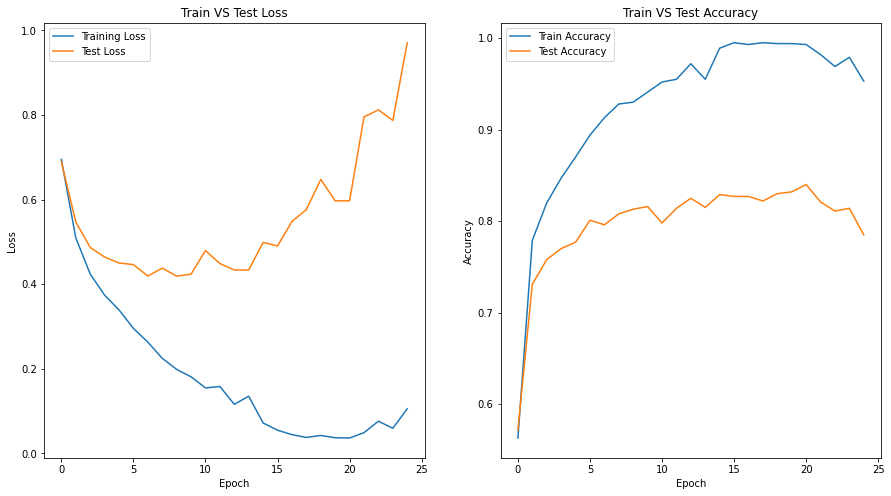

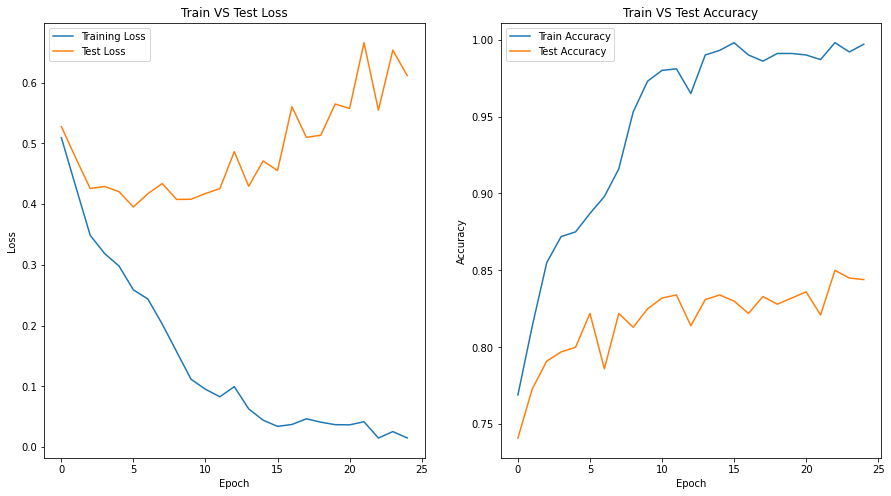

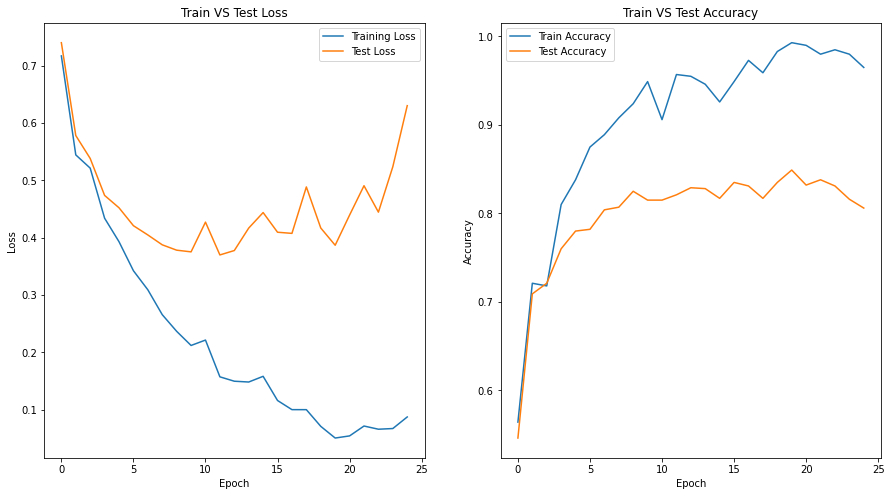

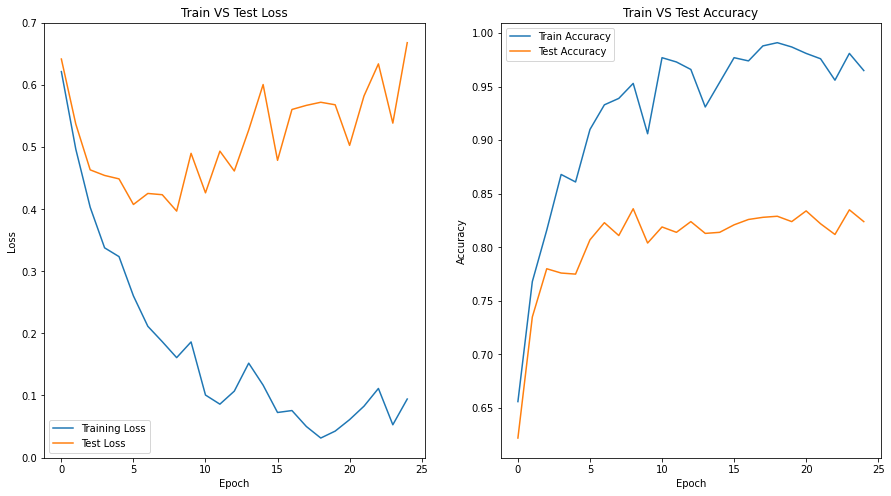

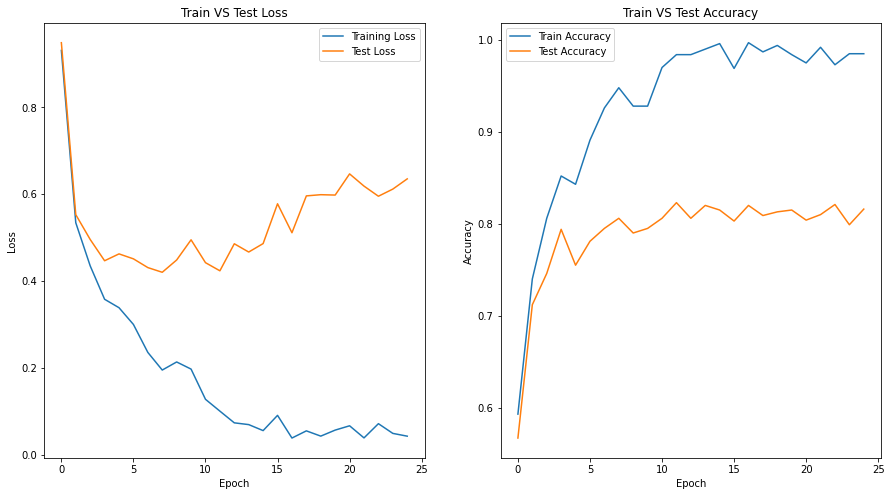

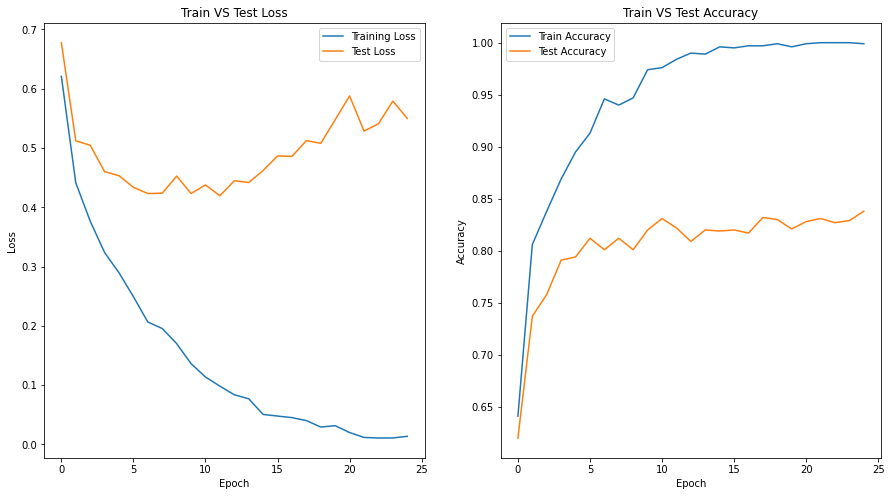

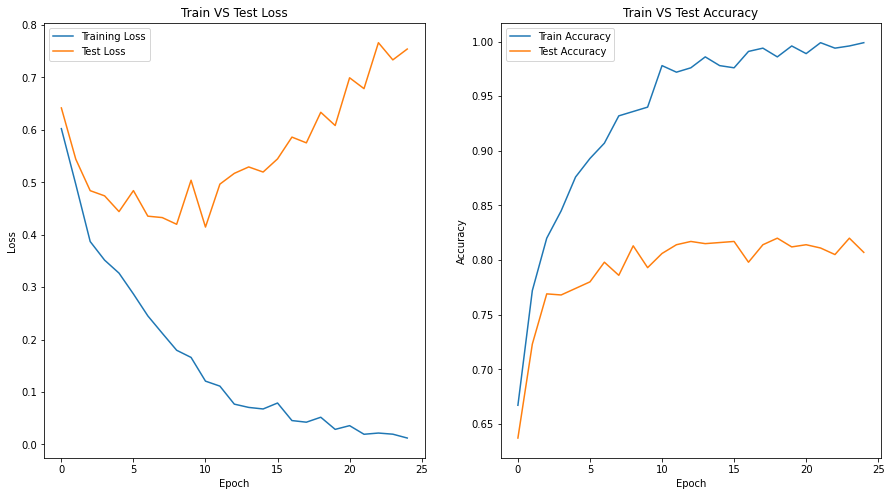

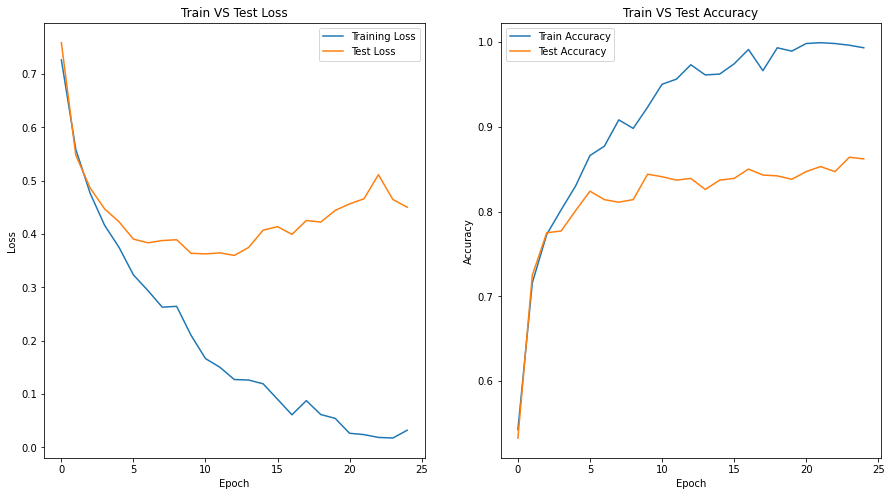

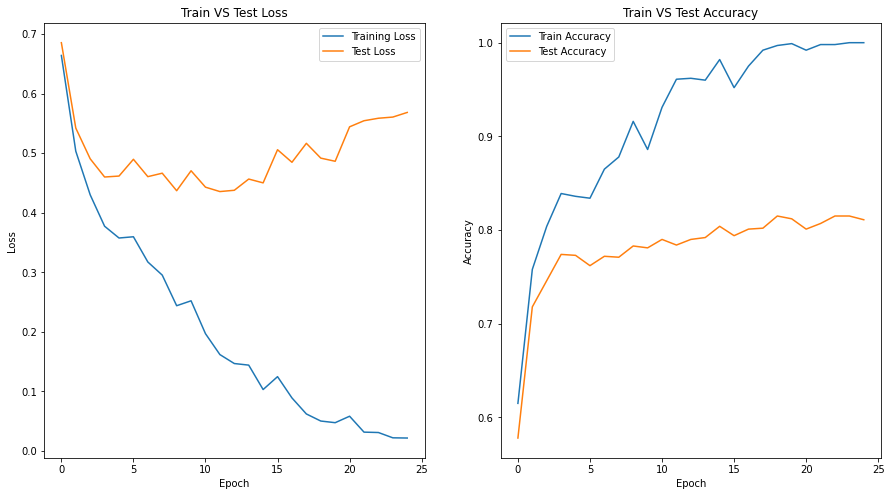

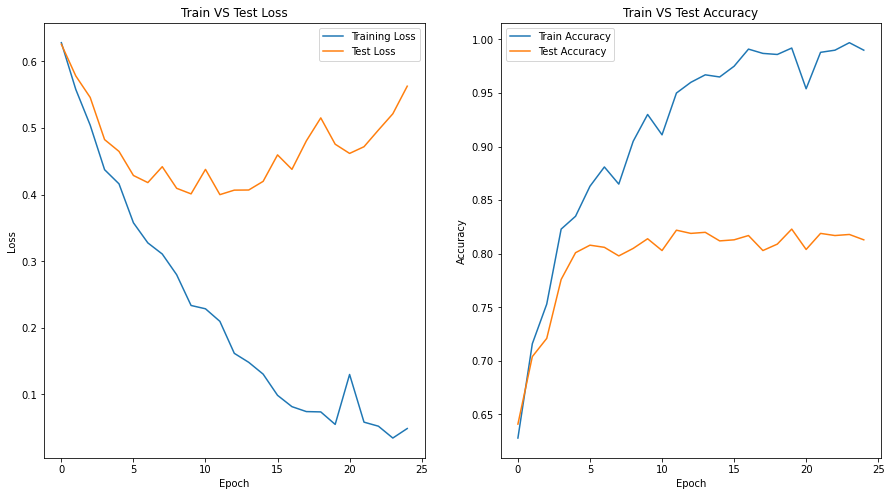

In [11]:
# calculate the standard deviation:
train_errors=[]
test_errors=[]
for num in range(10):
    N_PAIRS = 1000
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)
    my_model = CNN_Net_weight_sharing()
    # train the model
    my_model.trainer(train_input, train_target,test_input, test_target)
    train_errors.append(my_model.compute_error(train_input, train_target))
    test_errors.append(my_model.compute_error(test_input, test_target))

In [12]:
print('The standard deviation of train error:',np.std(np.divide(train_errors, 100)))
print('The standard deviation of test error:',np.std(np.divide(test_errors, 100)))
print('The mean of train error: %.1f%%'%np.mean(train_errors))
print('The mean of test error: %.1f%%'%np.mean(test_errors))

The standard deviation of train error: 0.0001634748093918321
The standard deviation of test error: 0.00021005706335618004
The mean of train error: 0.0%
The mean of test error: 0.2%


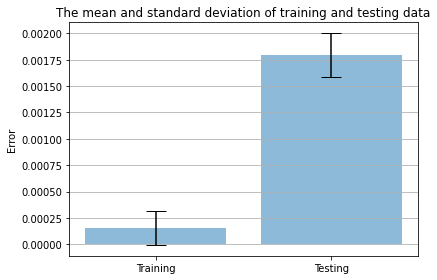

In [13]:
#plot the standard 
# Define labels, positions, bar heights and error bar heights
labels = ['Training', 'Testing']
x_pos = np.arange(len(labels))
means = [np.mean(train_errors)/100, np.mean(test_errors)/100]
stds = [np.std(np.divide(train_errors, 100)), np.std(np.divide(test_errors, 100))]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means,
       yerr=stds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Error')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('The mean and standard deviation of training and testing data')
ax.yaxis.grid(True)

# show the plot
plt.tight_layout()
plt.show()